### 0. Imports and requirements

* В данном соревновании мы имеем дело с последовательностями, один из интуитивных способов работы с ними &ndash; использование рекуррентных нейронных сетей. В этом базовом решении мы демонстрируем, как можно построить хорошее решение задачи соревнования без использования сложного и трудоемкого feature engineering'а (чтобы эффективно решать ту же задачу с высоким качеством с помощью бустингов нужно несколько тысяч признаков), благодаря рекуррентным нейронным сетям. В этом ноутбуке мы построим решение с использованием фреймфорка `torch`. Для комфортной работы Вам понадобится машина с `GPU` (хватит ресурсов `google colab` или `kaggle`).

In [147]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
import tqdm

# !!! измените "2" на номер доступной вам сuda
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
pd.set_option("display.max_columns", None)

# добавим родительскую директорию, в ней лежат все необходимые полезные функции для обработки данных
sys.path.append("../")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import matplotlib.pyplot as plt
# plt.style.use("seaborn-pastel")

### 1. Data Preprocessing

In [63]:
# TRAIN_DATA_PATH = "/trinity/home/team08/workspace/data/train_data/"
# TEST_DATA_PATH = "/trinity/home/team08/workspace/data/test_data/"

# TRAIN_TARGET_PATH = "/trinity/home/team08/workspace/data/train_target.csv"
# TEST_TARGET_PATH = "/trinity/home/team08/workspace/data/test_target.csv"

In [151]:
# Загрузка Parquet файла
file_path = '/trinity/home/team08/workspace/data/train_data/train_data_0.pq'
df = pd.read_parquet(file_path)

# Группировка данных по пользователю
user_groups = df.groupby('id')

# Создание списка групп
grouped_data = [group for _, group in user_groups]

# Определение размера каждой части
total_groups = len(grouped_data)
part_size = total_groups // 12

# Разделение на 12 частей, избегая разбиения истории одного пользователя
parts = []
for i in range(12):
    start_index = i * part_size
    end_index = (i + 1) * part_size if i < 11 else total_groups
    part = pd.concat(grouped_data[start_index:end_index])
    parts.append(part)

output_dir = '/trinity/home/team08/workspace/main_project/train_data'
os.makedirs(output_dir, exist_ok = True)

# Сохранение каждой части в отдельный Parquet файл
for i, part in enumerate(parts):
    part_file_path = os.path.join(output_dir, f'part_{i+1}.pqt')
    part.to_parquet(part_file_path)

print("Разделение завершено. Файлы сохранены.")

TRAIN_DATA_PATH = "/trinity/home/team08/workspace/main_project/train_data/"

# Загрузка Parquet файла
file_path = '/trinity/home/team08/workspace/data/test_data/test_data_0.pq'
df = pd.read_parquet(file_path)

# Группировка данных по пользователю
user_groups = df.groupby('id')

# Создание списка групп
grouped_data = [group for _, group in user_groups]

# Определение размера каждой части
total_groups = len(grouped_data)
part_size = total_groups // 2

# Разделение на 2 части, избегая разбиения истории одного пользователя
parts = []
for i in range(2):
    start_index = i * part_size
    end_index = (i + 1) * part_size if i < 1 else total_groups
    part = pd.concat(grouped_data[start_index:end_index])
    parts.append(part)

output_dir = '/trinity/home/team08/workspace/main_project/test_data'
os.makedirs(output_dir, exist_ok = True)

# Сохранение каждой части в отдельный Parquet файл
for i, part in enumerate(parts):
    part_file_path = os.path.join(output_dir, f'part_{i+1}.pqt')
    part.to_parquet(part_file_path)

print("Разделение завершено. Файлы сохранены.")

TEST_DATA_PATH = "/trinity/home/team08/workspace/main_project/test_data/"

Разделение завершено. Файлы сохранены.
Разделение завершено. Файлы сохранены.


In [152]:
features = ["pre_since_opened", "pre_since_confirmed", "pre_pterm", "pre_fterm", "pre_till_pclose", "pre_till_fclose",
            "pre_loans_credit_limit", "pre_loans_next_pay_summ", "pre_loans_outstanding", "pre_loans_total_overdue",
            "pre_loans_max_overdue_sum", "pre_loans_credit_cost_rate",
            "pre_loans5", "pre_loans530", "pre_loans3060", "pre_loans6090", "pre_loans90",
            "is_zero_loans5", "is_zero_loans530", "is_zero_loans3060", "is_zero_loans6090", "is_zero_loans90",
            "pre_util", "pre_over2limit", "pre_maxover2limit", "is_zero_util", "is_zero_over2limit", "is_zero_maxover2limit",
            "enc_paym_0", "enc_paym_1", "enc_paym_2", "enc_paym_3", "enc_paym_4", "enc_paym_5", "enc_paym_6", "enc_paym_7", "enc_paym_8",
            "enc_paym_9", "enc_paym_10", "enc_paym_11", "enc_paym_12", "enc_paym_13", "enc_paym_14", "enc_paym_15", "enc_paym_16",
            "enc_paym_17", "enc_paym_18", "enc_paym_19", "enc_paym_20", "enc_paym_21", "enc_paym_22", "enc_paym_23", "enc_paym_24",
            "enc_loans_account_holder_type", "enc_loans_credit_status", "enc_loans_credit_type", "enc_loans_account_cur",
            "pclose_flag", "fclose_flag"]

In [153]:
train_target = pd.read_csv(TRAIN_TARGET_PATH)
train_target = train_target.iloc[:20832]
train_target

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
20827,20827,0
20828,20828,0
20829,20829,0
20830,20830,0


In [154]:
test_target = pd.read_csv(TEST_TARGET_PATH)
test_target

,id
0,3000000
1,3000001
2,3000002
3,3000003
4,3000004
...,...
499995,3499995
499996,3499996
499997,3499997
499998,3499998


* Как и в случае с бустингами, мы не можем поместить всю выборку в память ввиду, например, ограниченных ресурсов. Для итеративного чтения данных нам потребуется функция `utils.read_parquet_dataset_from_local`, которая читает N частей датасета за раз в память.


* Нейронные сети требуют отдельного внимания к тому, как будут предобработаны и поданы данные. Важные моменты, на которые требуется обратить внимание:
    1. Использование рекуррентных сетей подразумевает работу на уровне последовательностей, где одна последовательность &ndash; все исторические кредиты клиента. Чтобы преобразовать `pd.DataFrame` с записями из кредитных историй клиентов в табличном виде к последовательностям, мы подготовили функцию `dataset_preprocessing_utils.transform_credits_to_sequences`, она производит необходимые манипуляции и возвращает фрейм с двумя колонками: `id` и `sequences`. Колонка `sequences` представляет из себя список списков длины `len(features)`, где каждый вложенный список &ndash; значения одного конкретного признака во всех кредитах клиента. 
    
    2. Клиенты могут иметь различные по длине кредитные истории. При этом обучение нейронных сетей происходит батчами и поскольку рекуррентные слои не способны обрабатывать батчи с последовательностями  неодинаковой длины, существует несколько подходов для приведения последовтельностей в батче к удобоваримому виду. Простой подход заключается в дополнении более коротких последовательностей нулями до максимальной длины последовательности в батче (т. н. паддинг). Довольно неэффективно делать паддинг внутри батча на последовательностях случайной длины (часто будем делать большой и бесполезный паддинг). Гораздо лучше использовать технику `Sequence Bucketing` (о ней мы рассказываем в нашем треке). Для реализации паддинга последовательностей кредитов клиентов мы подготовили функцию `dataset_preprocessing_utils.create_padded_buckets`.

In [155]:
import os
import pandas as pd
import tqdm
from typing import List


def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0, num_parts_to_read: int = 2, 
                                    columns: List[str] = None, verbose: bool = False) -> pd.DataFrame:
    """
    Читает ``num_parts_to_read`` партиций и преобразует их к pandas.DataFrame.

    Параметры:
    -----------
    path_to_dataset: str
        Путь до директории с партициями.
    start_from: int, default=0
        Номер партиции, с которой начать чтение.
    num_parts_to_read: int, default=2
        Число партиций, которые требуется прочитать.
    columns: List[str], default=None
        Список колонок, которые нужно прочитать из каждой партиции. Если None, то считываются все колонки.

    Возвращаемое значение:
    ----------------------
    frame: pandas.DataFrame
        Прочитанные партиции, преобразованные к pandas.DataFrame.
    """

    res = []
    start_from = max(0, start_from)
    # dictionory of format {partition number: partition filename}
    dataset_paths = {int(os.path.splitext(filename)[0].split("_")[-1]): os.path.join(path_to_dataset, filename)
                     for filename in os.listdir(path_to_dataset)}
    chunks = [dataset_paths[num] for num in sorted(dataset_paths.keys()) if num>=start_from][:num_parts_to_read]
    
    if verbose:
        print("Reading chunks:", *chunks, sep="\n")
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        chunk = pd.read_parquet(chunk_path, columns=columns)
        res.append(chunk)
    return pd.concat(res).reset_index(drop=True)

from typing import Dict
import numpy as np
import pandas as pd
import pickle

def pad_sequence(array: np.ndarray, max_len: int) -> np.ndarray:
    """
    Принимает на вход массив массивов ``array`` и производит padding каждого вложенного массива до ``max_len``.

    Параметры:
    -----------
    array: numpy.ndarray
        Входной массив массивов.
    max_len: int
        Длина, до которой нужно сделать padding вложенных массивов.

    Возвращаемое значение:
    ----------------------
    output: numpy.ndarray
        Выходной массив.
    """
    if isinstance(max_len, float):
        print(max_len)
    output = np.zeros((len(features), max_len))
    output[:, :array.shape[1]] = array
    return output


def truncate(x, num_last_credits: int = 0):
    return pd.Series({"sequences": x.values.transpose()[:, -num_last_credits:]})


def transform_credits_to_sequences(credits_frame: pd.DataFrame,
                                   num_last_credits: int = 0) -> pd.DataFrame:
    """
    Принимает pandas.DataFrame с записями кредитных историй клиентов, сортирует кредиты по клиентам
    (внутри клиента сортирует кредиты от старых к новым), берет ``num_last_credits`` кредитов,
    возвращает новый pandas.DataFrame с двумя колонками: id и sequences.
    Каждое значение в столбце sequences - это массив массивов.
    Каждый вложенный массив - значение одного признака во всех кредитах клиента.
    Всего признаков len(features), поэтому будет len(features) массивов.

    Параметры:
    -----------
    credits_frame: pandas.DataFrame
        Датафрейм с записями кредитных историй клиентов.
    num_last_credits: int, default=0
         Количество кредитов клиента, которые будут включены в выходные данные. Если 0, то берутся все кредиты.

    Возвращаемое значение:
    ----------------------
    output: pandas.DataFrame
        Выходной датафрейм с двумя столбцами: "id", "sequences".
    """
    return credits_frame \
        .sort_values(["id", "rn"]) \
        .groupby(["id"])[features] \
        .apply(lambda x: truncate(x, num_last_credits=num_last_credits)) \
        .reset_index()


def create_padded_buckets(frame_of_sequences: pd.DataFrame, bucket_info: Dict[int, int],
                          save_to_file_path: str = None, has_target: bool = True):
    """
    Реализует Sequence Bucketing технику для обучения рекуррентных нейронных сетей.
    Принимает на вход датафрейм ``frame_of_sequences`` с двумя столбцами: "id", "sequences"
    (результат работы функции transform_credits_to_sequences),
    словарь ``bucket_info``, где для последовательности каждой длины указано, до какой максимальной длины нужно делать
    padding, группирует кредиты по бакетам (на основе длины), производит padding нулями и сохраняет результат
    в pickle файл, если требуется.

    Параметры:
    -----------
    frame_of_sequences: pandas.DataFrame
        Входной датафрейм с двумя столбцами "id", "sequences" (результат работы функции transform_credits_to_sequences).
    bucket_info: Dict[int, int]
        Cловарь, где для последовательности каждой длины указано, до какой максимальной длины нужно делать padding.
    save_to_file_path: str, default=None
        Опциональный путь до файла, куда нужно сохранить результат. Если None, то сохранение не требуется.
    has_target: bool, deafult=True
        Флаг, есть ли в frame_of_sequences целевая переменная или нет. Если есть, то она также будет записана в выходной словарь.

    Возвращаемое значение:
    ----------------------
    dict_result: dict
        Выходной словарь со ключами:  "id", "padded_sequences", "target".
    """
    frame_of_sequences["sequence_length"] = frame_of_sequences["sequences"].apply(lambda x: len(x[1]))
    frame_of_sequences["bucket_idx"] = frame_of_sequences["sequence_length"].map(bucket_info)
    padded_seq = []
    targets = []
    ids = []

    for size, bucket in tqdm.notebook.tqdm(frame_of_sequences.groupby("bucket_idx"), desc="Extracting buckets"):
        padded_sequences = bucket["sequences"].apply(lambda x: pad_sequence(x, size)).values
        padded_seq.append(np.stack(padded_sequences, axis=0))

        if has_target:
            targets.append(bucket["flag"].values)

        ids.append(bucket["id"].values)

    frame_of_sequences.drop(columns=["bucket_idx"], inplace=True)

    dict_result = {
        "id": np.array(ids, dtype=np.object_),
        "padded_sequences": np.array(padded_seq, dtype=np.object_),
        "target": np.array(targets, dtype=np.object_) if targets else []
    }

    if save_to_file_path:
        with open(save_to_file_path, "wb") as f:
            pickle.dump(dict_result, f)
    return dict_result


* В дальнейшем при построении рекуррентной нейронной сети нам понадобятся следующие статистики по тренировочной и тестовой выборкам: распределение длин кредитных историй и число уникальных значений каждого категориального значения. Посчитаем эти статистики:

In [156]:
%%time
from collections import defaultdict
import tqdm

train_lens = []
test_lens = []
uniques = defaultdict(set)

for step in tqdm.tqdm(range(0, 12, 4),
                     desc="Count statistics on train data"):
        credits_frame = read_parquet_dataset_from_local(TRAIN_DATA_PATH, step, 4, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        train_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
train_lens = np.hstack(train_lens)

for step in tqdm.tqdm(range(0, 2, 2),
                     desc="Count statistics on test data"):
        credits_frame = read_parquet_dataset_from_local(TEST_DATA_PATH, step, 2, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        test_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
test_lens = np.hstack(test_lens)
uniques = dict(uniques)

Count statistics on train data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
/trinity/home/team08/workspace/main_project/train_data/part_1.pqt
/trinity/home/team08/workspace/main_project/train_data/part_2.pqt
/trinity/home/team08/workspace/main_project/train_data/part_3.pqt
/trinity/home/team08/workspace/main_project/train_data/part_4.pqt


/tmp/ipykernel_313592/248440550.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on train data:  33%|███▎      | 1/3 [00:00<00:00,  2.82it/s]

Reading chunks:
/trinity/home/team08/workspace/main_project/train_data/part_4.pqt
/trinity/home/team08/workspace/main_project/train_data/part_5.pqt
/trinity/home/team08/workspace/main_project/train_data/part_6.pqt
/trinity/home/team08/workspace/main_project/train_data/part_7.pqt


/tmp/ipykernel_313592/248440550.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on train data:  67%|██████▋   | 2/3 [00:00<00:00,  2.81it/s]

Reading chunks:
/trinity/home/team08/workspace/main_project/train_data/part_8.pqt
/trinity/home/team08/workspace/main_project/train_data/part_9.pqt
/trinity/home/team08/workspace/main_project/train_data/part_10.pqt
/trinity/home/team08/workspace/main_project/train_data/part_11.pqt


/tmp/ipykernel_313592/248440550.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on test data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
/trinity/home/team08/workspace/main_project/test_data/part_1.pqt
/trinity/home/team08/workspace/main_project/test_data/part_2.pqt


/tmp/ipykernel_313592/248440550.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Count statistics on test data: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


CPU times: user 4.5 s, sys: 2.26 s, total: 6.76 s
Wall time: 2.84 s


* Чтобы сразу убедиться, что посчитанные статистики интересные и полезные, построим графики распределений длин кредитных историй в тренировочной и тестовой выборках

In [157]:
from collections import Counter


train_len_counter = pd.Series(Counter(train_lens)).sort_index()
test_len_counter = pd.Series(Counter(test_lens)).sort_index()

<BarContainer object of 46 artists>

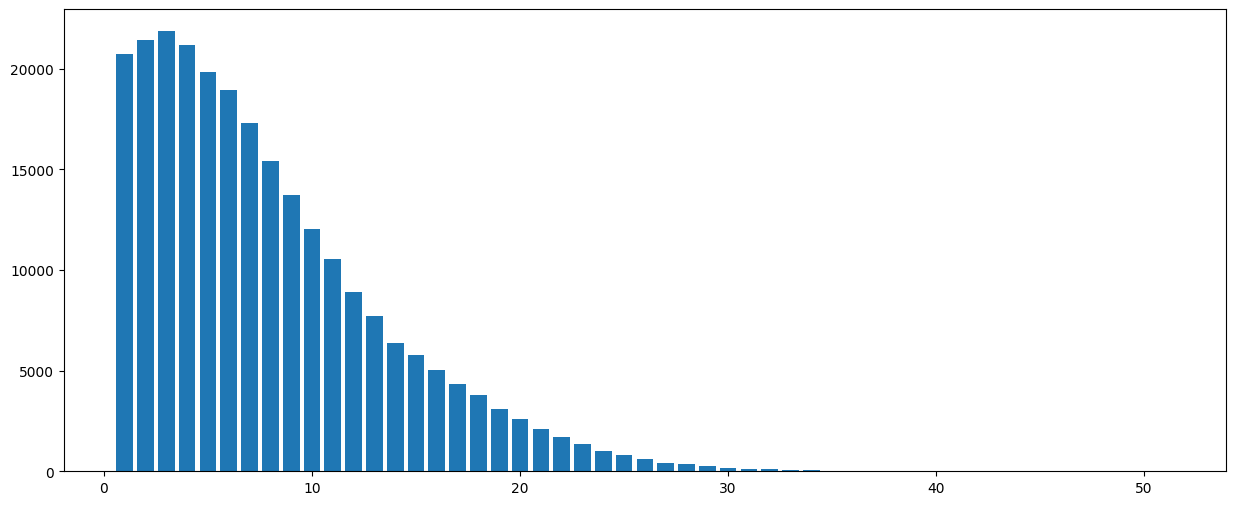

In [158]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(train_len_counter.index.values, train_len_counter.values)

<BarContainer object of 46 artists>

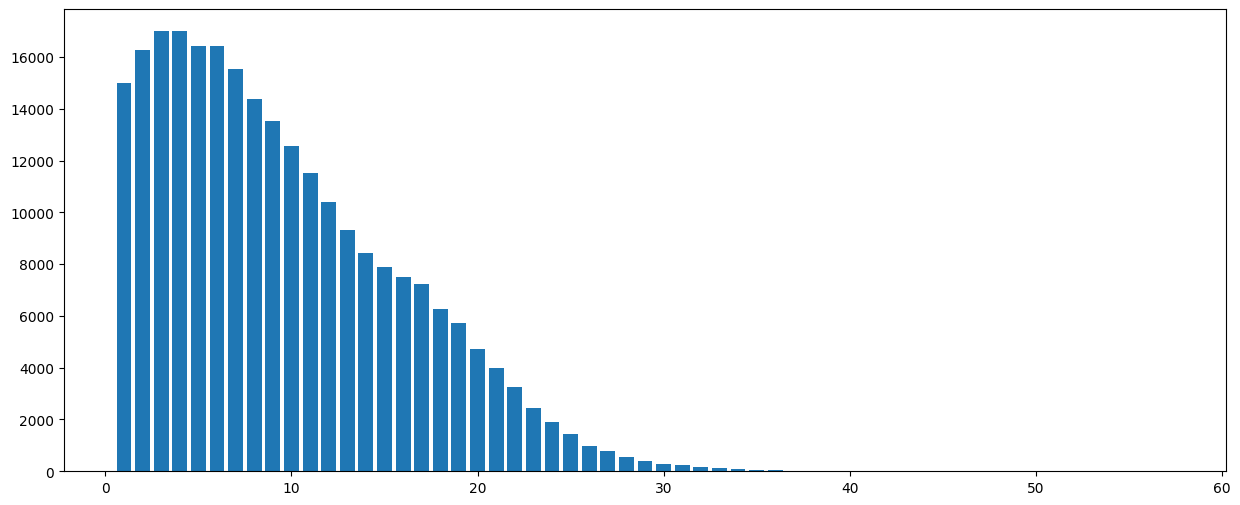

In [159]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(test_len_counter.index.values, test_len_counter.values)

In [160]:
train_lens.max(), test_lens.max()

(51, 57)

* Один из аргументов в функции `dataset_preprocessing_utils.create_padded_buckets` &ndash; `bucket_info` &ndash; словарь, где для конкретной длины последовательности указано до какой длины нужно делать паддинг. Для данного бэйзлайна возьмем простое разбиение на 43 бакета: 
| Длина последовательности | Длина после паддинга |
| :-: | :-: 
| 1 &ndash; 40 | без изменений |
| 41 &ndash; 45 | 45 |
| 46 &ndash; 50 | 50 |
| 51 &ndash; 58 | 58 |

In [161]:
keys_ = list(range(1, 59)) 
lens_ = list(range(1, 41)) + [45] * 5 + [50] * 5 + [58] * 8
bucket_info = dict(zip(keys_, lens_))
bucket_info

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 45,
 42: 45,
 43: 45,
 44: 45,
 45: 45,
 46: 50,
 47: 50,
 48: 50,
 49: 50,
 50: 50,
 51: 58,
 52: 58,
 53: 58,
 54: 58,
 55: 58,
 56: 58,
 57: 58,
 58: 58}

* Так же рассмотрим уникальные значения признаков

In [162]:
for feat, uniq in uniques.items():
    print(f"Feature: {feat}, unique values: {uniq}")

Feature: pre_since_opened, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_since_confirmed, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_pterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_fterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_pclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_fclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
Feature: pre_loans_credit_limit, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_loans_next_pay_summ, unique values: {0, 1, 2, 3, 4, 5, 6}
Feature: pre_loans_outstanding, unique values: {1, 2, 3, 4, 5}
Feature: pre_loans_total_overdue, unique values: {0}
Feature: pre_loans_max_overdue_sum, unique values: {1, 2, 3}
Feature: pre_loans_credi

* Поскольку паддинг будет производиться нулями, а категориальные признаки закодированы, начиная с 0, перед паддингом будем сдвигать все значения на 1.

* Вся описанная выше предобработка данных реализована в виде функции `create_buckets_from_credits`:

In [163]:
def create_buckets_from_credits(path_to_dataset, bucket_info, save_to_path, frame_with_ids = None, 
                                num_parts_to_preprocess_at_once: int = 1, 
                                num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Preparing credit data"):
        credits_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=True)
        credits_frame.loc[:, features] += 1       
        seq = transform_credits_to_sequences(credits_frame)
        print("Transforming credits to sequences is done.")
        
        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on="id")

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = "00" + block_as_str
        else:
            block_as_str = "0" + block_as_str
            
        processed_fragment =  create_padded_buckets(seq, bucket_info=bucket_info, has_target=has_target, 
                                                    save_to_file_path=os.path.join(save_to_path, 
                                                                                   f"processed_chunk_{block_as_str}.pkl"))
        block += 1

* Разобьем обучающие данные на тренировочную и валидационную выборки. Воспользуемся самым простым способом &ndash; для валидации случайным образом выберем 10% обучающих данных.

In [164]:
train, val = train_test_split(train_target, random_state=42, test_size=0.1)
train.shape, val.shape

((18748, 2), (2084, 2))

In [165]:
# TRAIN_BUCKETS_PATH = "/trinity/home/team08/workspace/main_project/train_buckets_rnn"
# VAL_BUCKETS_PATH = "/trinity/home/team08/workspace/main_project/val_buckets_rnn"
# TEST_BUCKETS_PATH = "/trinity/home/team08/workspace/main_project/test_buckets_rnn"

# TRAIN_BUCKETS_PATH = "/trinity/home/team08/workspace/data/train_buckets_rnn"
# VAL_BUCKETS_PATH = "/trinity/home/team08/workspace/data/val_buckets_rnn"
# TEST_BUCKETS_PATH = "/trinity/home/team08/workspace/data/test_buckets_rnn"

# TRAIN_DATA_PATH = "/trinity/home/team08/workspace/data/train_data/"
# TEST_DATA_PATH = "/trinity/home/team08/workspace/data/test_data/"

In [166]:
# for buckets_path in [TRAIN_BUCKETS_PATH, VAL_BUCKETS_PATH, TEST_BUCKETS_PATH]:
#     !rm -rf $buckets_path
#     !mkdir $buckets_path

In [167]:
# %%time
# create_buckets_from_credits(TRAIN_DATA_PATH,
#                             bucket_info=bucket_info,
#                             save_to_path=TRAIN_BUCKETS_PATH,
#                             frame_with_ids=train,
#                             num_parts_to_preprocess_at_once=4, 
#                             num_parts_total=12, has_target=True)

# dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
# dataset_train

In [168]:
%%time
# create_buckets_from_credits(TRAIN_DATA_PATH,
#                             bucket_info=bucket_info,
#                             save_to_path=VAL_BUCKETS_PATH,
#                             frame_with_ids=val,
#                             num_parts_to_preprocess_at_once=4, 
#                             num_parts_total=12, has_target=True)

# dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
# dataset_val

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs


In [169]:
# %%time
# create_buckets_from_credits(TEST_DATA_PATH,
#                             bucket_info=bucket_info,
#                             save_to_path=TEST_BUCKETS_PATH, num_parts_to_preprocess_at_once=2, 
#                             num_parts_total=2)

# dataset_test = sorted([os.path.join(TEST_BUCKETS_PATH, x) for x in os.listdir(TEST_BUCKETS_PATH)])
# dataset_test

### 2. Modeling

In [170]:
import torch

In [171]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


* Для создания модели будем использовать фреймворк `torch`. В нем есть все, чтобы писать произвольные сложные архитектуры и быстро экспериментировать. Для того, чтобы мониторить и логировать весь процесс во время обучения сетей, рекомендуется использовать надстройки над данным фреймворком, например, `lightning`.

* В бейзлайне мы предлагаем базовые компоненты, чтобы можно было обучать нейронную сеть и отслеживать ее качество. Для этого вам предоставлены следующие функции:
    * `data_generators.batches_generator` &ndash; функция-генератор, итеративно возвращает батчи, поддерживает батчи для `tensorflow.keras` и `torch.nn.Module` моделей. В зависимости от флага `is_train` может быть использована для генерации батчей на train/val/test стадии.
    * функция `pytorch_training.train_epoch` &ndash; обучает модель одну эпоху.
    * функция `pytorch_training.eval_model` &ndash; проверяет качество модели на отложенной выборке и возвращает roc_auc_score.
    * функция `pytorch_training.inference` &ndash; делает предикты на новых данных и готовит фрейм для проверяющей системы.
    * класс `training_aux.EarlyStopping` &ndash; реализует early_stopping, сохраняя лучшую модель. Пример использования приведен ниже.

In [172]:
###from data_generators import batches_generator



from typing import List
import numpy as np
import pickle
import torch


def batches_generator(list_of_paths: List[str], batch_size: int = 32, shuffle: bool = False,
                      is_infinite: bool = False, verbose: bool = False, device: torch.device = None,
                      output_format: str = "torch", is_train: bool = True):
    """
    Создает батчи на вход рекуррентных нейронных сетей, реализованных на фреймворках tensorflow и pytorch.

    Параметры:
    -----------
    list_of_paths: List[str]
        Список путей до файлов с предобработанными последовательностями.
    batch_size: int, default=32
        Размер батча.
    shuffle: bool, default=False
        Перемешивать ли данные перед генерацией батчей.
    is_infinite: bool, default=False
        Должен ли генератор быть бесконечным.
    verbose: bool, default=False
        Печатать ли имя текущего обрабатываемого файла.
    device: torch.device, default=None
        Девайс, на который переместить данные при ``output_format``="torch". Игнорируется, если ``output_format``="tf".
    output_format: str, default="torch"
        Формат возвращаемых данных. Допустимые значения: "torch", "tf".
        Если "torch", то возвращает словарь, с ключами "id_", "features" и "label", если is_train=True,
        и содержащий идентификаторы заявок, признаки и тагрет соответственно.
        Признаки и таргет помещаются на девайс, указанный в ``device``.
        Если "tf", то возращает кортеж (признаки, таргет), если ``is_train``=True, и кортеж (признаки, идентификаторы заявок) иначе.
    is_train: bool, default=True
        Используется ли генератор для обучения модели или для инференса.

    Возвращаемое значение:
    ----------------------
    result: dict or tuple
        Выходной словарь или кортеж в зависимости от параметра ``output_format``.
    """
    if output_format not in ["torch", "tf"]:
        raise ValueError("Unknown format. Please choose one of the following formats: \"torch\", \"tf\"")

    while True:
        if shuffle:
            np.random.shuffle(list_of_paths)

        for path in list_of_paths:
            if verbose:
                print(f"Reading {path}")

            with open(path, "rb") as f:
                data = pickle.load(f)

            ids, padded_sequences, targets = data["id"], data["padded_sequences"], data["target"]
            indices = np.arange(len(ids))
            if shuffle:
                np.random.shuffle(indices)
                ids = ids[indices]
                padded_sequences = padded_sequences[indices]
                if is_train:
                    targets = targets[indices]

            for idx in range(len(ids)):
                bucket_ids = ids[idx]
                bucket = padded_sequences[idx]
                if is_train:
                    bucket_targets = targets[idx]

                for jdx in range(0, len(bucket), batch_size):
                    batch_ids = bucket_ids[jdx: jdx + batch_size]
                    batch_sequences = bucket[jdx: jdx + batch_size]
                    if is_train:
                        batch_targets = bucket_targets[jdx: jdx + batch_size]

                    if output_format == "tf":
                        batch_sequences = [batch_sequences[:, i] for i in range(len(features))]

                        if is_train:
                            yield batch_sequences, batch_targets
                        else:
                            yield batch_sequences, batch_ids
                    else:
                        batch_sequences = [torch.LongTensor(batch_sequences[:, i]).to(device) for i in range(len(features))]
                        if is_train:
                            yield dict(id_=batch_ids,
                                       features=batch_sequences,
                                       label=torch.LongTensor(batch_targets).to(device))
                        else:
                            yield dict(id_=batch_ids,
                                       features=batch_sequences)
        if not is_infinite:
            break


###from pytorch_training import train_epoch, eval_model, inference


from typing import List
import torch
import pandas as pd
import torch.nn as nn
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score



def train_epoch(model: torch.nn.Module, optimizer: torch.optim.Optimizer, dataset_train: List[str],
                batch_size: int = 64, shuffle: bool = True, print_loss_every_n_batches: int = 500,
                device: torch.device = None):
    """
    Делает одну эпоху обучения модели, логируя промежуточные значения функции потерь.

    Параметры:
    -----------
    model: torch.nn.Module
        Обучаемая модель.
    optimizer: torch.optim.Optimizer
        Оптимизатор.
    dataset_train: List[str]
        Список путей до файлов с предобработанными последовательностями.
    batch_size: int, default=64
        Размер батча.
    shuffle: bool, default=False
        Перемешивать ли данные перед подачей в модель.
    print_loss_every_n_batches: int, default=500
        Число батчей.
    device: torch.device, default=None
        Девайс, на который переместить данные.

    Возвращаемое значение:
    ----------------------
    None
    """
    model.train()
    loss_function = nn.BCEWithLogitsLoss(reduction="none")
    losses = torch.LongTensor().to(device)
    samples_counter = 0
    train_generator = batches_generator(dataset_train, batch_size=batch_size, shuffle=shuffle,
                                        device=device, is_train=True, output_format="torch")

    for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):
        output = torch.flatten(model(batch["features"]))
        batch_loss = loss_function(output, batch["label"].float())
        batch_loss.mean().backward()
        optimizer.step()
        optimizer.zero_grad()

        samples_counter += batch_loss.size(0)

        losses = torch.cat([losses, batch_loss], dim=0)
        if num_batch % print_loss_every_n_batches == 0:
            print(f"Batches {num_batch - print_loss_every_n_batches + 1} - {num_batch} loss:"
                  f"{losses[-samples_counter:].mean()}", end="\r")
            samples_counter = 0

    print(f"Training loss after epoch: {losses.mean()}", end="\r")


def eval_model(model: torch.nn.Module, dataset_val: List[str], batch_size: int = 32, device: torch.device = None) -> float:
    """
    Скорит выборку моделью и вычисляет метрику ROC AUC.

    Параметры:
    -----------
    model: torch.nn.Module
        Модель, которой необходимо проскорить выборку.
    dataset_val: List[str]
        Список путей до файлов с предобработанными последовательностями.
    batch_size: int, default=32
        Размер батча.
    device: torch.device, default=None
        Девайс, на который переместить данные.

    Возвращаемое значение:
    ----------------------
    auc: float
    """
    model.eval()
    preds = []
    targets = []
    val_generator = batches_generator(dataset_val, batch_size=batch_size, shuffle=False,
                                      device=device, is_train=True, output_format="torch")

    for batch in tqdm_notebook(val_generator, desc="Evaluating model"):
        targets.extend(batch["label"].detach().cpu().numpy().flatten())
        output = model(batch["features"])
        preds.extend(output.detach().cpu().numpy().flatten())

    return roc_auc_score(targets, preds)


def inference(model: torch.nn.Module, dataset_test: List[str], batch_size: int = 32, device: torch.device = None) -> pd.DataFrame:
    """
    Скорит выборку моделью.

    Параметры:
    -----------
    model: torch.nn.Module
        Модель, которой необходимо проскорить выборку.
    dataset_test: List[str]
        Список путей до файлов с предобработанными последовательностями.
    batch_size: int, default=32
        Размер батча.
    device: torch.device, default=None
        Девайс, на который переместить данные.

    Возвращаемое значение:
    ----------------------
    scores: pandas.DataFrame
        Датафрейм с двумя колонками: "id" - идентификатор заявки и "score" - скор модели.
    """
    model.eval()
    preds = []
    ids = []
    test_generator = batches_generator(dataset_test, batch_size=batch_size, shuffle=False,
                                       verbose=False, device=device, is_train=False,
                                       output_format="torch")

    for batch in tqdm_notebook(test_generator, desc="Test predictions"):
        ids.extend(batch["id_"])
        output = model(batch["features"])
        preds.extend(output.detach().cpu().numpy().flatten())

    return pd.DataFrame({
        "id": ids,
        "score": preds
    })

import torch
import numpy as np


class EarlyStopping:
    """
    Останавливает обучение модели, если валидационная метрика не улучшается в течение заданного числа эпох.

    Параметры:
    ----------
    patience: int, default=7
        Допустимое число эпох без улучшения валидационной метрики.
        Валидационная метрика должна улучшаться как минимум каждые ``patience`` эпох, иначе обучение останавливается.
    mode: str, default="min"
        Режим работы. Допустимые значения: "min", "max" - минимизация или максимизация целевой метрики соответственно.
    verbose: bool, default=False
        Печатать ли сообщение при каждом улучшении валидационной метрики.
    delta: int, default=0
        Минимальное изменение контролируемой метрики, которое можно считать улучшением.
    save_path: str, default="checkpoint.hdf5"
        Путь до файла, в который необходимо сохранять лучшую модель.
    metric_name: str, default=None
        Имя метрики.
    save_format: str, default="torch"
        Формат модели. Допустимые значения: "torch", "tf" - для моделей на фреймворках pytorch и tensorflow.keras соответственно.
    """

    def __init__(self, patience=7, mode='min', verbose=False, delta=0, save_path='checkpoint.hdf5', metric_name=None, save_format='torch'):
        if mode not in ["min", "max"]:
            raise ValueError(f"Unrecognized mode: {mode}! Please choose one of the following modes: \"min\", \"max\"")

        if save_format not in ["torch", "tf"]:
            raise ValueError(f"Unrecognized format: {save_format}! Please choose one of the following formats: \"torch\", \"tf\"")

        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_prev_score = np.Inf if mode == "min" else -np.Inf
        self.delta = delta
        self.save_path = save_path
        self.metric_name = "metric" if not metric_name else metric_name
        self.save_format = save_format

    def __call__(self, metric_value, model):

        score = -metric_value if self.mode == "min" else metric_value

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(metric_value, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                f"No imporvement in validation {self.metric_name}. Current: {score:.6f}. Current best: {self.best_score:.6f}")
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(metric_value, model)
            self.counter = 0

    def save_checkpoint(self, metric_value: float, model: torch.nn.Module or tensorflow.keras.Model):
        """
        Cохраняет модель, если валидационная метрика улучшилась.

        Параметры:
        ----------
        metric_value: float
            Значение валидационной метрики.
        model: torch.nn.Module or tensorflow.keras.Model
            Обучаемая модель.

        Возвращаемое значение:
        ----------------------
        None
        """
        if self.verbose:
            print(
                f"Validation {self.metric_name} improved ({self.best_prev_score:.6f} --> {metric_value:.6f}).  Saving model...")
        if self.save_format == "tf":
            model.save_weights(self.save_path)
        else:
            torch.save(model.state_dict(), self.save_path)

        self.best_prev_score = metric_value


* Все признаки, описывающие кредитную историю клиентов &ndash; категориальные. Для их представления в модели используем категориальные эмбеддинги. Для этого нужно каждому категориальному признаку задать размерность латентного пространства. Используем [формулу](https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608) из библиотеки `fast.ai`.

In [173]:
def compute_embed_dim(n_cat: int) -> int:
    return min(600, round(1.6 * n_cat**0.56))

In [174]:
embedding_projections = {feat: (max(uniq)+1, compute_embed_dim(max(uniq)+1)) for feat, uniq in uniques.items()}
embedding_projections

{'pre_since_opened': (20, 9),
 'pre_since_confirmed': (18, 8),
 'pre_pterm': (18, 8),
 'pre_fterm': (17, 8),
 'pre_till_pclose': (17, 8),
 'pre_till_fclose': (16, 8),
 'pre_loans_credit_limit': (20, 9),
 'pre_loans_next_pay_summ': (7, 5),
 'pre_loans_outstanding': (6, 4),
 'pre_loans_total_overdue': (1, 2),
 'pre_loans_max_overdue_sum': (4, 3),
 'pre_loans_credit_cost_rate': (14, 7),
 'pre_loans5': (17, 8),
 'pre_loans530': (20, 9),
 'pre_loans3060': (10, 6),
 'pre_loans6090': (6, 4),
 'pre_loans90': (20, 9),
 'is_zero_loans5': (2, 2),
 'is_zero_loans530': (2, 2),
 'is_zero_loans3060': (2, 2),
 'is_zero_loans6090': (2, 2),
 'is_zero_loans90': (2, 2),
 'pre_util': (20, 9),
 'pre_over2limit': (20, 9),
 'pre_maxover2limit': (20, 9),
 'is_zero_util': (2, 2),
 'is_zero_over2limit': (2, 2),
 'is_zero_maxover2limit': (2, 2),
 'enc_paym_0': (4, 3),
 'enc_paym_1': (4, 3),
 'enc_paym_2': (4, 3),
 'enc_paym_3': (4, 3),
 'enc_paym_4': (4, 3),
 'enc_paym_5': (4, 3),
 'enc_paym_6': (4, 3),
 'enc_pay

* Реализуем модель. Все входные признаки представим в виде эмбеддингов, сконкатенируем, чтобы получить векторное представление транзакции. Подадим последовательности в `GRU` рекуррентный слой. Используем последнее скрытое состояние в качестве выхода слоя. На основе такого входа построим небольшой `MLP`, выступающий классификатором для целевой задачи. Используем градиентный спуск, чтобы решить оптимизационную задачу.

In [175]:
class CreditsRNN(nn.Module):
    def __init__(self, features, embedding_projections, rnn_units=128, top_classifier_units=32):
        super(CreditsRNN, self).__init__()
        self._credits_cat_embeddings = nn.ModuleList([self._create_embedding_projection(*embedding_projections[feature]) 
                                                          for feature in features])
                        
        self._gru = nn.GRU(input_size=sum([embedding_projections[x][1] for x in features]),
                             hidden_size=rnn_units, batch_first=True, bidirectional=False)
        self._hidden_size = rnn_units
        self._top_classifier = nn.Linear(in_features=rnn_units, out_features=top_classifier_units)
        self._intermediate_activation = nn.ReLU()
        self._head = nn.Linear(in_features=top_classifier_units, out_features=1)
    
    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)
        
        _, last_hidden = self._gru(concated_embeddings)
        last_hidden = torch.reshape(last_hidden.permute(1, 2, 0), shape=(batch_size, self._hidden_size))
                                
        classification_hidden = self._top_classifier(last_hidden)
        activation = self._intermediate_activation(classification_hidden)
        raw_output = self._head(activation)
        return raw_output
    
    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality+add_missing, embedding_dim=embed_size, padding_idx=padding_idx)

### 3. Training

In [176]:
!rm -rf /trinity/home/team08/workspace/main_project/./checkpoints/
!mkdir /trinity/home/team08/workspace/main_project/./checkpoints/

In [177]:
!rm -r /trinity/home/team08/workspace/main_project/./checkpoints/pytorch_baseline
!mkdir /trinity/home/team08/workspace/main_project/./checkpoints/pytorch_baseline

rm: cannot remove '/trinity/home/team08/workspace/main_project/./checkpoints/pytorch_baseline': No such file or directory


* Для того, чтобы детектировать переобучение используем EarlyStopping.

In [178]:
path_to_checkpoints = "/trinity/home/team08/workspace/main_project/./checkpoints/pytorch_baseline/"
es = EarlyStopping(patience=3, mode="max", verbose=True, save_path=os.path.join(path_to_checkpoints, "best_checkpoint.pt"), 
                   metric_name="ROC-AUC", save_format="torch")

In [179]:
num_epochs = 10
train_batch_size = 128
val_batch_size = 128

In [180]:
model = CreditsRNN(features, embedding_projections).to(device)

In [181]:
model

CreditsRNN(
  (_credits_cat_embeddings): ModuleList(
    (0): Embedding(21, 9, padding_idx=0)
    (1-2): 2 x Embedding(19, 8, padding_idx=0)
    (3-4): 2 x Embedding(18, 8, padding_idx=0)
    (5): Embedding(17, 8, padding_idx=0)
    (6): Embedding(21, 9, padding_idx=0)
    (7): Embedding(8, 5, padding_idx=0)
    (8): Embedding(7, 4, padding_idx=0)
    (9): Embedding(2, 2, padding_idx=0)
    (10): Embedding(5, 3, padding_idx=0)
    (11): Embedding(15, 7, padding_idx=0)
    (12): Embedding(18, 8, padding_idx=0)
    (13): Embedding(21, 9, padding_idx=0)
    (14): Embedding(11, 6, padding_idx=0)
    (15): Embedding(7, 4, padding_idx=0)
    (16): Embedding(21, 9, padding_idx=0)
    (17-21): 5 x Embedding(3, 2, padding_idx=0)
    (22-24): 3 x Embedding(21, 9, padding_idx=0)
    (25-27): 3 x Embedding(3, 2, padding_idx=0)
    (28-38): 11 x Embedding(5, 3, padding_idx=0)
    (39): Embedding(6, 4, padding_idx=0)
    (40-47): 8 x Embedding(5, 3, padding_idx=0)
    (48): Embedding(6, 4, padding_i

In [182]:
optimizer = torch.optim.Adam(lr=1e-3, params=model.parameters())

In [183]:
dataset_train

['/trinity/home/team08/workspace/data/train_buckets_rnn/processed_chunk_000.pkl',
 '/trinity/home/team08/workspace/data/train_buckets_rnn/processed_chunk_002.pkl',
 '/trinity/home/team08/workspace/data/train_buckets_rnn/processed_chunk_001.pkl']

* Запустим цикл обучения, каждую эпоху будем логировать лосс, а так же ROC-AUC на валидации и на обучении. Будем сохрнаять веса после каждой эпохи, а так же лучшие с помощью early_stopping.

In [184]:
%%time
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}")
    train_epoch(model, optimizer, dataset_train, batch_size=train_batch_size, 
                shuffle=True, print_loss_every_n_batches=500, device=device)
    
    val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_size, device=device)
    es(val_roc_auc, model)
    
    if es.early_stop:
        print("Early stopping reached. Stop training...")
        break
    torch.save(model.state_dict(), os.path.join(path_to_checkpoints, f"epoch_{epoch+1}_val_{val_roc_auc:.3f}.pt"))
    
    train_roc_auc = eval_model(model, dataset_train, batch_size=val_batch_size, device=device)
    print(f"Epoch {epoch+1} completed. Train ROC AUC: {train_roc_auc}, val ROC AUC: {val_roc_auc}")

Starting epoch 1


/tmp/ipykernel_313592/1505826781.py:146: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_batch, batch in tqdm_notebook(enumerate(train_generator, start=1), desc="Training"):


Training: 0it [00:00, ?it/s]

TypeError: only integer scalar arrays can be converted to a scalar index

### 4. Submission

* Подготовим посылку в проверяющую систему

In [52]:
path_to_checkpoints

'/trinity/home/team08/workspace/data/./checkpoints/pytorch_baseline/'

In [54]:
model.load_state_dict(torch.load(os.path.join(path_to_checkpoints, "best_checkpoint.pt"), map_location=torch.device('cpu')))

<All keys matched successfully>

In [53]:
model.load_state_dict(torch.load(os.path.join(path_to_checkpoints, "best_checkpoint.pt")))

RuntimeError: Attempting to deserialize object on CUDA device 0 but torch.cuda.device_count() is 0. Please use torch.load with map_location to map your storages to an existing device.

In [55]:
test_preds = inference(model, dataset_test, batch_size=128, device=device)

Test predictions: 0it [00:00, ?it/s]

In [62]:
train_preds = inference(model, dataset_train, batch_size=128, device=device)
train_preds

Test predictions: 0it [00:00, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/trinity/home/team08/workspace/data/train_buckets_rnn/processed_chunk_002.pkl'

In [56]:
test_preds.head()

,id,score
0,3000014,-3.209836
1,3000020,-1.469409
2,3000027,-3.320151
3,3000043,-1.958419
4,3000049,-3.275137


In [57]:
test_preds.shape

(500000, 2)

In [58]:
test_preds.to_csv("/trinity/home/team08/workspace/rnn_baseline/torch_submission.csv", index=None) # ~ 0.765 на public test

In [ ]:
from sklearn.metrics import roc_auc_score
print("Test roc-auc: ", roc_auc_score(, test_preds)) 
# Train roc-auc gb:  0.8790580266970891
# val ROC AUC pytorch: 0.7705235440545772